In [2]:
import h5py
import glob
import numpy as np
year = 2001
fn_list = sorted(glob.glob('/storage/coda1/p-rbras6/0/njadidoleslam3/gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/{year}/*/*.HDF5'.format(year = year)))


In [6]:
data_temp = np.ones((360, 1800, int(len(fn_list)/2)), dtype=np.float16)

In [1]:
# %%timeit 
def read_h5(fn, lon_i):
    try:
        f = h5py.File(fn, 'r')
        dset = f['Grid/precipitationCal'][0,360*lon_i:360*(lon_i+1),:]
        dset[dset==-9999.9] = -99
        return dset.astype(np.float16)
    except:
        return np.ones((360, 1800), dtype=np.float16)* -99

for lon_i in range(0, 10):     # iterating over 5 regions divided by longitude
    data_temp = np.ones((360, 1800, int(len(fn_list)/2)), dtype=np.float16)
    for i in range(int(len(fn_list)/2)):
        fn1 = fn_list[2*i]
        fn2 = fn_list[2*i + 1]
        dset1 = read_h5(fn1, lon_i)
        dset2 = read_h5(fn2, lon_i)
        average = np.array((dset1,dset2)).mean(axis=0)
        data_temp[:, :, i] = average.astype(np.float16)


NameError: name 'np' is not defined

In [6]:
sum((dset1[:,200] + dset2[:,200])/2 == average[:,200]) == len(average[:,200])

True

In [4]:
############## CHECKING DATA SIZE CONSISTENCY FOR ALL YEARS ##############
with open('/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/gpm_analysis/trash/data_len.txt', 'w') as f_log:
        
    for year in range(2001,2021):
        fn_list = sorted(glob.glob('/storage/coda1/p-rbras6/0/njadidoleslam3/gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/{year}/*/*.HDF5'.format(year = year)))
        print(int(len(fn_list)/2))
        f_log.write('{year}, {len}, {odd_even} \n'.format(year = year , len = len(fn_list), odd_even = len(fn_list) %2 == 0))
f_log.close()
############## OK ##############

8760
8760
8760
8784
8760
8760
8760
8784
8760
8760
8760
8784
8760
8760
8760
8784
8760
8760
8760
8784


In [5]:
np.array([99]).astype(np.float16) < 65535

array([ True])

In [7]:
print('Size of data with 100 timestamps: {:.2f}'.format(data_temp.nbytes/1024**3) , 'GB')
print('Size of final data: {:.2f}'.format(data_temp.nbytes/(1024**3)) , 'GB')

Size of data with 100 timestamps: 10.60 GB
Size of final data: 10.60 GB


In [13]:
a = np.random.normal(size = (360,1800,9000))

In [ ]:
a.nbytes/1024**3

array([ 360.37434185, 1800.23017455, 8998.73822473])

# test performance with GDAL and chunks of the array

In [68]:
from osgeo import gdal
import glob
import numpy as np
year = 2001
fn_list = sorted(glob.glob('/storage/coda1/p-rbras6/0/njadidoleslam3/gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.06/{year}/*/*.HDF5'.format(year = year)))

fn_temp = 'HDF5:"{fn}"://Grid/precipitationCal'

In [69]:
# %%timeit
for lon_i in range(0, 5):     # iterating over 3600 elements
    
    data_temp = np.ones((360, 1800, len(fn_list[0:100])), dtype=np.int16)
    for i, fn in enumerate(fn_list[0:100]):
        fn_in = fn_temp.format(fn = fn)
        f = gdal.Open(fn_in)
        dset = f.ReadAsArray()[360*lon_i:360*(lon_i+1),:]
        dset[dset==-9999.9] = -99
        data_temp[:, :, i] = dset.astype(np.int16)

In [62]:
print('Size of data with 100 timestamps: {:.2f}'.format(data_temp.nbytes/1024**3) , 'GB')
print('Size of final data: {:.2f}'.format(data_temp.nbytes/(1024**3)*len(fn_list)/100) , 'GB')

Size of data with 100 timestamps: 0.12 GB
Size of final data: 21.15 GB


# test performance without chunk

In [70]:
# %%timeit
fn_temp = 'HDF5:"{fn}"://Grid/precipitationCal'
for lon_i in range(0, 1):     # iterating over 3600 elements
    
    data_temp = np.ones((3600, 1800, len(fn_list[0:100])), dtype=np.float16)
    for i, fn in enumerate(fn_list[0:100]):
        fn_in = fn_temp.format(fn = fn)
        f = gdal.Open(fn_in)
        dset = f.ReadAsArray()
        dset[dset==-9999.9] = -99
        # dset = dset*100
        data_temp[:, :, i] = dset.astype(np.float16)

In [74]:
print('Size of final data: {:.2f}'.format(data_temp.nbytes/1024**3*len(fn_list)/100) , 'GB')

Size of final data: 211.47 GB


# Test result:

## Only difference is the 

In [75]:
import xarray as xar

In [76]:

drop_vars =  [
    'time_bnds',
 'lon_bnds',
 'lat_bnds',
 'precipitationUncal',
 'randomError',
 'HQprecipitation',
 'HQprecipSource',
 'HQobservationTime',
 'IRprecipitation',
 'IRkalmanFilterWeight',
 'probabilityLiquidPrecipitation',
 'precipitationQualityIndex']
dset = xar.open_mfdataset(fn_list[:100], parallel = False, group='Grid', data_vars='minimal', drop_variables=drop_vars, concat_dim=['time'], coords=['time'], combine='by_coords')

In [77]:
aa = dset.load()

In [81]:
aa.nbytes/1024**3*len(fn_list)/100

422.93437242507935

In [78]:
aa['precipitationCal'][:,0,0]

<xarray.DataArray 'precipitationCal' (time: 100)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)
Coordinates:
  * time     (time) object 2001-01-01 00:00:00 ... 2001-01-03 01:30:00
    lon      float32 -179.9
    lat      float32 -89.95
Attributes:
    DimensionNames:    time,lon,lat
    Units:             mm/hr
    units:             mm/hr
    CodeMissingValue:  -9999.9

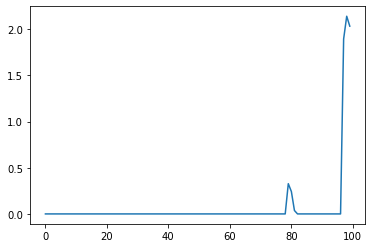

In [47]:
import matplotlib.pyplot as plt
# plt.plot(dset[:,0])
plt.plot(data_temp[340,500,:])

In [40]:
fn_in = fn_temp.format(fn = fn_list[10000])
f = gdal.Open(fn_in)
%timeit dset = f.ReadAsArray()[:,0:180]
%timeit dset = f.ReadAsArray()[0:145, :]



4.26 ms ± 79.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.53 ms ± 36.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# lon, lat =np.meshgrid(lon,lat)

fig, ax = plt.subplots(figsize=(20,10))
a = ax.imshow(data1[:, :, i], vmin=0, vmax = 500, cmap=plt.cm.Blues)
cax = plt.axes([0.92, 0.25, 0.02, 0.5])
plt.colorbar(a, cax=cax)